# $node2vec$ on emails data

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import pandas as pd 
import numpy as np
import networkx as nx

In [3]:
from datetime import datetime

## Data reading

In [4]:
edges = pd.read_csv('../data/emails/edges.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/emails/labels.csv', header=None, 
                     names=('node','label'))
labels_list = list(labels['label'].unique())

n_clusters = len(labels['label'].unique())

In [5]:
G = nx.Graph()
G.add_nodes_from(labels['node'])

for i, row in edges.iterrows():
    G.add_edge(row['from'],row['to'], weight=1)

## Data visualisation

In [6]:
import matplotlib.pyplot as plt

__All departments' members distribution__

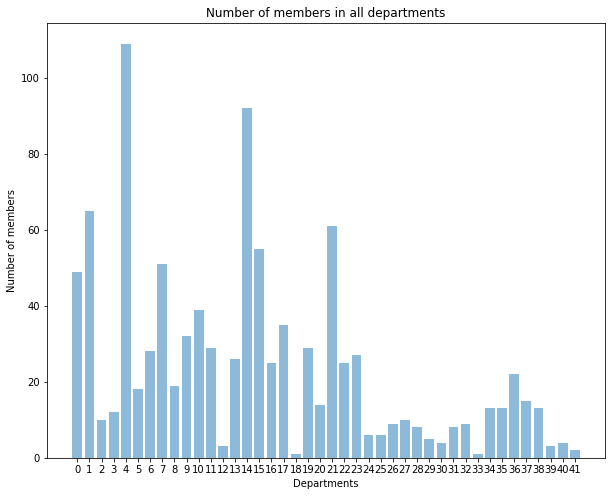

In [7]:
# all departments' members distribution
performance = []
dep_freq = labels['label'].value_counts()
objects = range(42)
for i in objects:
    performance.append(dep_freq[i])
y_pos = np.arange(len(objects))

plt.figure(figsize=[10,8])
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of members')
plt.xlabel('Departments')
plt.title('Number of members in all departments')

plt.show()

__Ten biggest departments distribution__

In [8]:
dep_nunique = labels.groupby('label')['node'].nunique().sort_values(ascending=False)
ten_deps = dep_nunique.head(10)

# pick up of the ten biggest departments memebers
nodes = []
deps = []
nodes_dict = {}

for index, row in labels.iterrows():
    if (row['label'] in ten_deps):
        nodes.append(row['node'])
        deps.append(row['label'])
        nodes_dict[row['node']] = row['label']

ten_departments = pd.DataFrame(list(zip(nodes, deps)), 
               columns =['node', 'label']) 
dep_freq = labels['label'].value_counts()
ten_dep_freq = ten_departments['label'].value_counts()

In [9]:
# edges for ten departments
toes = []
froms = []

for index, row in edges.iterrows():
    if (row['from'] in nodes_dict and row['to'] in nodes_dict):
        toes.append(row['to'])
        froms.append(row['from'])
 
ten_edges = pd.DataFrame(list(zip(froms, toes)), 
               columns =['from', 'to']) 

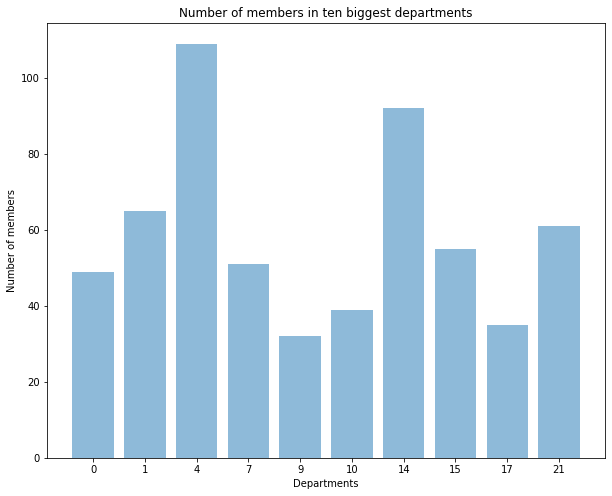

In [10]:
# ten departments' member distribution
ten_performance = []
ten_objects = ten_dep_freq.index
ten_objects = ten_objects.sort_values()
ten_objects.sort

for i in ten_objects:
    ten_performance.append(ten_dep_freq[i])

ten_y_pos = np.arange(len(ten_objects))

plt.figure(figsize=[10,8])
plt.bar(ten_y_pos, ten_performance, align='center', alpha=0.5)
plt.xticks(ten_y_pos, ten_objects)
plt.ylabel('Number of members')
plt.xlabel('Departments')
plt.title('Number of members in ten biggest departments')

plt.show()

## Input/output of the original graph for Gephi 

In [11]:
#input for Gephi - graph representation of ten biggest departments
with open('../gephi/ten_data.gdf', 'w') as f:
    f.write('nodedef>name VARCHAR,department VARCHAR,label VARCHAR\n')
    for index, row in ten_departments.iterrows():
        f.write('{},{}\n'.format(row['node'], row['label']))
    f.write('edgedef>source VARCHAR,target VARCHAR, weight DOUBLE\n')
    for index, row in ten_edges.iterrows(): 
        f.write('{},{}\n'.format(row['from'], row['to'], 1))

## Cluster analisys

In [12]:
from objfun_node2vec import N2V

In [13]:
#initialization
n2v = N2V('../data/emails/edges.csv',
            '../data/emails/labels.csv')

In [14]:
n2v_ten = N2V('../data/emails/ten_edges.csv',
            '../data/emails/ten_labels.csv')

Calculation time comparision:

In [15]:
import time

In [16]:
start_time = time.time()
value_full = n2v.evaluate(p=0.5, q=2, num_walks=10, len_walks=100, window=5)
print ("Time:", time.time() - start_time, ' sec')
print ("Value:", value_full)

Time: 225.2926881313324  sec
Value: 0.4157692894056561


In [17]:
start_time = time.time()
value_ten = n2v_ten.evaluate(p=0.5, q=2, num_walks=10, len_walks=100, window=5)
print ("Time:", time.time() - start_time, ' sec')
print ("Value:", value_ten)

Time: 53.80012011528015  sec
Value: 0.7351861270230906


## Parameters sensitivity

In [18]:
def write_to_file(res,param):
    now = datetime.now()
    current_time = now.strftime('%Y%m%d_emails_ten_'+param)
    filename = '../results/' + current_time + '.csv'
    res.to_csv(filename)

In [19]:
res = pd.DataFrame(columns=['walk_length','num_walks',
                            'p','q',
                            'window',
                            'adj_rand'])

for walk_length in range(20,120,10):
    for num_walks in [10]:
        for p in [1]:
            for q in [1]:
                for window in [10]:
                    adj_rand = n2v.evaluate(p,q,num_walks,walk_length,window)

                    res = res.append({'walk_length':walk_length,
                                      'num_walks':num_walks,
                                      'p':p,'q':q,
                                      'window':window,
                                      'adj_rand':adj_rand},ignore_index=True)
                            
write_to_file(res,'walk_length')

In [20]:
res = pd.DataFrame(columns=['walk_length','num_walks',
                            'p','q',
                            'window',
                            'adj_rand'])

for walk_length in [80]:
    for num_walks in range(6,24,2):
        for p in [1]:
            for q in [1]:
                for window in [10]:
                    adj_rand = n2v.evaluate(p,q,num_walks,walk_length,window)

                    res = res.append({'walk_length':walk_length,
                                      'num_walks':num_walks,
                                      'p':p,'q':q,
                                      'window':window,
                                      'adj_rand':adj_rand},ignore_index=True)
                            
write_to_file(res,'num_walks')

In [21]:
res = pd.DataFrame(columns=['walk_length','num_walks',
                            'p','q',
                            'window',
                            'adj_rand'])

for walk_length in [80]:
    for num_walks in [10]:
        for p in [0.25, 0.5, 1., 2., 4]:
            for q in [1.0]:
                for window in [10]:
                    adj_rand = n2v.evaluate(p,q,num_walks,walk_length,window)

                    res = res.append({'walk_length':walk_length,
                                      'num_walks':num_walks,
                                      'p':p,'q':q,
                                      'window':window,
                                      'adj_rand':adj_rand},ignore_index=True)
                            
write_to_file(res,'p')

In [22]:
res = pd.DataFrame(columns=['walk_length','num_walks',
                            'p','q',
                            'window',
                            'adj_rand'])

for walk_length in [80]:
    for num_walks in [10]:
        for p in [1.0]:
            for q in [0.25, 0.5, 1., 2., 4]:
                for window in [10]:
                    adj_rand = n2v.evaluate(p,q,num_walks,walk_length,window)

                    res = res.append({'walk_length':walk_length,
                                      'num_walks':num_walks,
                                      'p':p,'q':q,
                                      'window':window,
                                      'adj_rand':adj_rand},ignore_index=True)
                            
write_to_file(res,'q')

In [23]:
res = pd.DataFrame(columns=['walk_length','num_walks',
                            'p','q',
                            'window',
                            'adj_rand'])

for walk_length in [80]:
    for num_walks in [10]:
        for p in [1.0]:
            for q in [1.0]:
                for window in range(2,22,2):
                    adj_rand = n2v.evaluate(p,q,num_walks,walk_length,window)

                    res = res.append({'walk_length':walk_length,
                                      'num_walks':num_walks,
                                      'p':p,'q':q,
                                      'window':window,
                                      'adj_rand':adj_rand},ignore_index=True)
                            
write_to_file(res,'window')

## Visualization of the results

In [24]:
now = datetime.now()
current_time = now.strftime('%Y%m%d')

res_walk_length = pd.read_csv('../results/'+current_time+'_emails_ten_walk_length.csv')
res_num_walks = pd.read_csv('../results/'+current_time+'_emails_ten_num_walks.csv')
res_p = pd.read_csv('../results/'+current_time+'_emails_ten_p.csv')
res_q = pd.read_csv('../results/'+current_time+'_emails_ten_q.csv')
res_window = pd.read_csv('../results/'+current_time+'_emails_ten_window.csv')

In [25]:
x1 = res_walk_length['walk_length']
y1 = res_walk_length['adj_rand'].tolist()

x2 = res_num_walks['num_walks']
y2 = res_num_walks['adj_rand'].tolist()

x3 = res_window['window']
y3 = res_window['adj_rand'].tolist()

x4 = res_p['p']
y4 = res_p['adj_rand'].tolist()

x5 = res_q['q']
y5 = res_q['adj_rand'].tolist()

Text(0, 0.5, 'score')

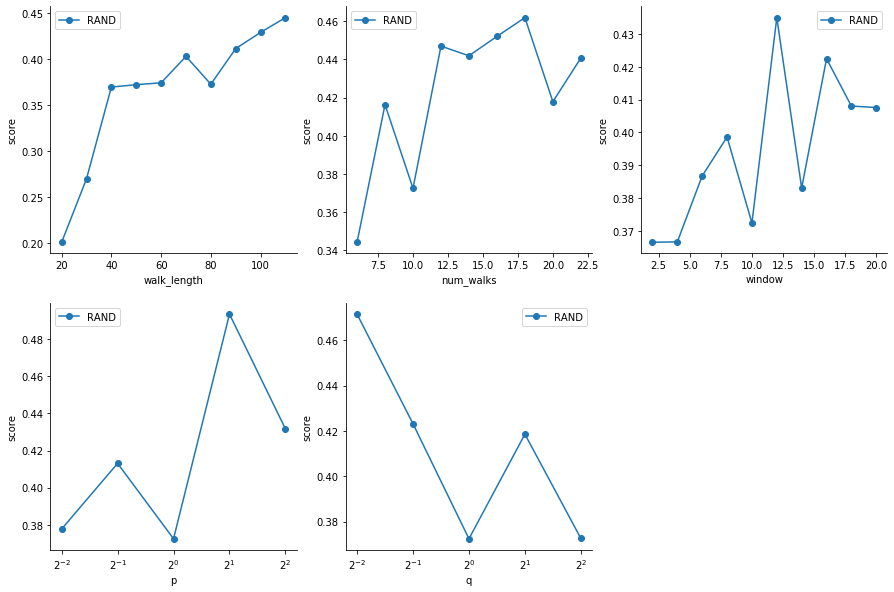

In [26]:
plt.figure(figsize=[15,10])

plt.subplot(231)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x1,y1,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('walk_length')
plt.ylabel('score')

plt.subplot(232)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x2,y2,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('num_walks')
plt.ylabel('score')

plt.subplot(233)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x3,y3,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('window')
plt.ylabel('score')

plt.subplot(234)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x4,y4,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='best', frameon=True)
plt.xlabel('p')
plt.ylabel('score')

plt.subplot(235)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x5,y5,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='best', frameon=True)
plt.xlabel('q')
plt.ylabel('score')

In [28]:
data = pd.read_csv("../results/emails_params.csv") 

In [36]:
data.sort_values(by=['adj_rand'], ascending=False).head(5)

,walk_length,num_walks,p,q,window,adj_rand
18,80.0,10.0,2.0,1.00,10.0,0.493557
10,80.0,10.0,1.0,0.25,10.0,0.471517
26,80.0,18.0,1.0,1.00,10.0,0.461952
25,80.0,16.0,1.0,1.00,10.0,0.452113
23,80.0,12.0,1.0,1.00,10.0,0.447016


## Conclusion

- $node2vec$ on emails data detects half of the clusters right, i.e. the Rand index is about $0.49$.